In [106]:
import pandas as pd

# Data Loading

In [107]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())

     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2  

# Data Split

In [108]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    df_train[i] = df_train[i].drop(columns=['id'], axis=1).copy(deep=True)
    x, y = data_handler.split_data(data=df_train[i], cols_name_split=['target'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    df_test[i] = df_test[i].drop(columns=['id'], axis=1).copy(deep=True)
    x, y = data_handler.split_data(data=df_test[i], cols_name_split=['target'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [109]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(f"Monk {i+1} [TR]: " + str(x_train[i].shape))
    print(f"Monk {i+1} [TS]: " + str(x_test[i].shape))

Monk 1 [TR]: (124, 17)
Monk 1 [TS]: (432, 17)
Monk 2 [TR]: (169, 17)
Monk 2 [TS]: (432, 17)
Monk 3 [TR]: (122, 17)
Monk 3 [TS]: (432, 17)


# Grid Search parameters

In [110]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
    0: {
        'input_size': [17],
        'hidden_size': [3],
        'output_size': [1],
        'hidden_layers': [1],
        'hidden_activation': ['Tanh'],
        'output_activation': ['Sigmoid'],
        'tolerance': [0.01],
        'learning_rate': [0.96, 0.95],
        'batch_size': [7, 8],
        'momentum': [0.8, 0.9],
        'weight_init': ["glorot_normal"],
        'seed_init': [7],
        'epochs': [350, 400],
        'weight_decay': [0],
        'nesterov': [False],
        'metrics': ['Accuracy']
    },
    1: {
        'input_size': [17],
        'hidden_size': [4],
        'output_size': [1],
        'hidden_layers': [1],
        'hidden_activation': ['Tanh'],
        'output_activation': ['Sigmoid'],
        'tolerance': [0.01],
        'learning_rate': [0.7, 0.8],
        'batch_size': [2, 3],
        'momentum': [0.7, 0.9],
        'weight_init': ["glorot_uniform"],
        'seed_init': [62],
        'epochs': [350, 400],
        'weight_decay': [0],
        'optimizer': ['SGD'],
        'nesterov': [False],
        'metrics': ['Accuracy'],
        'decimal_cypher_degree': [0]
    },
    2: {
        'input_size': [17],
        'hidden_size': [3],
        'output_size': [1],
        'hidden_layers': [1],
        'hidden_activation': ['Tanh'],
        'output_activation': ['Sigmoid'],
        'tolerance': [0.025],
        'learning_rate': [0.05, 0.03],
        'batch_size': [2, 3],
        'momentum': [0],
        'weight_init': ["glorot_uniform"], #["glorot_uniform", "glorot_normal", "he_uniform", "he_normal"],
        'seed_init': [62],
        'epochs': [350, 400],
        'weight_decay': [0.001],
        'nesterov': [False],
        'metrics': ['Accuracy']
    }
}


# Model Selection

## Best Hyperparameters Research

In [111]:
from sklearn.model_selection import StratifiedKFold
from api.pytorch.nn import NN

# Creation of a BinaryNN objct for each dataset
nn: list[NN] = []

# Different values per dataset
#trials_list = [5, 5, 5]   # 30, 30, 50
k_values = [5, 5, 5]

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values.astype(dtype=float)
    y = y_train[dataset_i].values.astype(dtype=float)
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Sets all the combinations of the entire set of parameters
    data_handler.set_params_combinations(params=param_space[dataset_i])

    # Gets the list with the combinations of all the parameters
    params_combinations = data_handler.get_params_combinations()

    # For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
    for trial, params in enumerate(params_combinations):
    #for trial in range(trials_list[dataset_i]):

        # Choose random hyperparameters
        #params = data_handler.random_dictionary(params=param_space[dataset_i])

        # Creation of the Neural Network object
        #nn_i = NN(params=params, current_trial=trial+1, trials=trials_list[dataset_i], monk_i=dataset_i+1)
        nn_i = NN(params=params, current_trial=trial+1, trials=len(params_combinations), monk_i=dataset_i+1)
                        
        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)
        
        # Print the results of this trial
        print("\n------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("-------------------- Best Hyperparameters -------------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Case of update with best hyperparameters
        if nn_i.is_better_model_than(nn[dataset_i]):
            nn[dataset_i] = nn_i
        
        # Particular exit case
        if nn_i.mean_tr_metric == 1 and nn_i.mean_vl_metric == 1 \
            and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
            and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
            nn[dataset_i] = nn_i
            break

    # Print output
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    print("\n\n")



------------------ Current Hyperparameters ------------------
 Monk:                     1
 Trial:                    1/16
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.96, 'batch_size': 7, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 7, 'epochs': 350, 'weight_decay': 0, 'nesterov': False, 'metrics': 'Accuracy'}
 Mean Training Loss:       0.007348081639986474
 Mean Validation Loss:     0.01643943895098851
 Mean Training Accuracy:   0.9908680272108824
 Mean Validation Accuracy: 0.9794438775510208
-------------------- Best Hyperparameters -------------------
 Monk:                     1
 Trial:                    1/16
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.96

## Print of best Hyperparameters

In [112]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()



### Best Hyperparameters for Monk 1 ###
 Monk:                     1
 Trial:                    9/16
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.96, 'batch_size': 7, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 7, 'epochs': 400, 'weight_decay': 0, 'nesterov': False, 'metrics': 'Accuracy'}
 Mean Training Loss:       0.007723968473816868
 Mean Validation Loss:     0.008263618670869707
 Mean Training Accuracy:   0.9896012115093388
 Mean Validation Accuracy: 0.9903773346794549

### Best Hyperparameters for Monk 2 ###
 Monk:                     2
 Trial:                    11/16
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.7, 'batch_size': 3, 'momentum': 0.7, 'weigh

## Retraining Phase


### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    9/16
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.96, 'batch_size': 7, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 7, 'epochs': 400, 'weight_decay': 0, 'nesterov': False, 'metrics': 'Accuracy'}
 Mean Training Loss:       0.007659376525498544
 Mean Validation Loss:     0.008263618670869707
 Mean Training Accuracy:   0.9896886575232756
 Mean Validation Accuracy: 0.9903773346794549


AttributeError: 'NN' object has no attribute 'print_acc_plot'

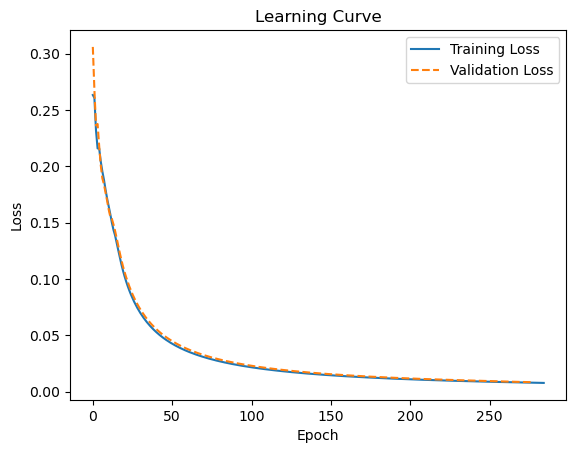

In [115]:
import matplotlib.pyplot as plt

def print_acc_plot(history):
    '''
        Prints the plot based on the accuracy of the trained model.
    '''
    plt.figure()
    plt.plot(history['tr_metric'], label='Training Accuracy')
    plt.plot(history['vl_metric'], label='Validation Accuracy', linestyle='--')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Training the model
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    nn[dataset_i].print_loss_plot()
    nn[dataset_i].print_acc_plot()

# Testing Phase

 Monk:                     1
 Trial:                    9
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.96, 'batch_size': 7, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 7, 'epochs': 400, 'weight_decay': 0, 'nesterov': False, 'metrics': 'Accuracy'}
 Mean Training Loss:       0.007691532743501398
 Mean Validation Loss:     0.008263618670869707
 Mean Test Loss:           6.893701120427592e-05
 Mean Training Accuracy:   0.9896451191313964
 Mean Validation Accuracy: 0.9903773346794549
 Mean Test Accuracy:        1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Prediction score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                  0                216


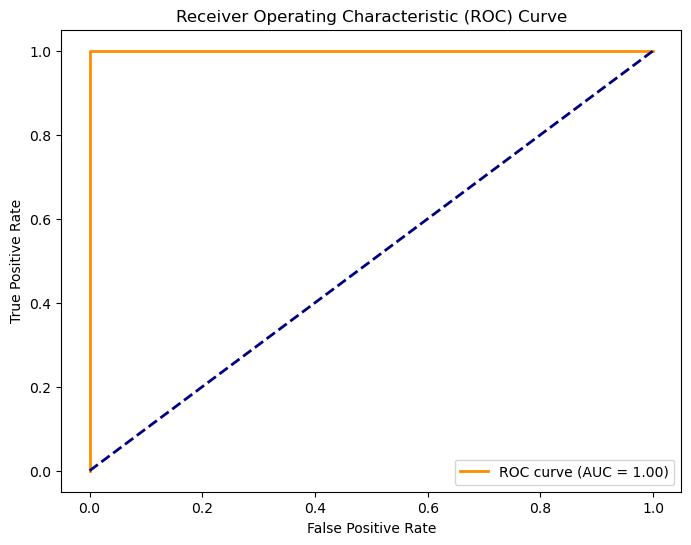

 Monk:                     2
 Trial:                    11
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.7, 'batch_size': 3, 'momentum': 0.7, 'weight_init': 'glorot_uniform', 'seed_init': 62, 'epochs': 400, 'weight_decay': 0, 'optimizer': 'SGD', 'nesterov': False, 'metrics': 'Accuracy', 'decimal_cypher_degree': 0}
 Mean Training Loss:       0.006273953023095182
 Mean Validation Loss:     0.0064739838821840385
 Mean Test Loss:           5.707780410880837e-05
 Mean Training Accuracy:   0.9906537093091179
 Mean Validation Accuracy: 0.9923045767517213
 Mean Test Accuracy:        1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Prediction score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                290                  0
Real_Class_1                  0 

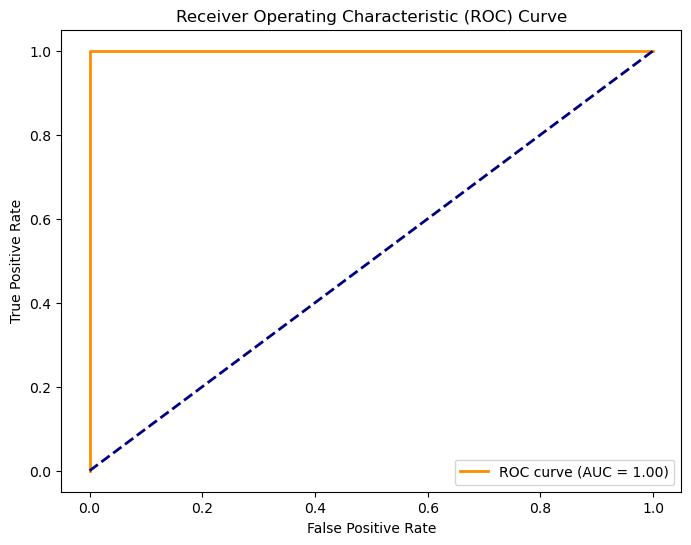

 Monk:                     3
 Trial:                    6
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.025, 'learning_rate': 0.03, 'batch_size': 2, 'momentum': 0, 'weight_init': 'glorot_uniform', 'seed_init': 62, 'epochs': 400, 'weight_decay': 0.001, 'nesterov': False, 'metrics': 'Accuracy'}
 Mean Training Loss:       0.026557108968263604
 Mean Validation Loss:     0.047550478111345815
 Mean Test Loss:           0.025029368504981563
 Mean Training Accuracy:   0.9805835143431131
 Mean Validation Accuracy: 0.9571774193548386
 Mean Test Accuracy:        0.9699074074074074
 f1 score:                 0.9706546275395034
 f2 score:                 0.9538598047914818
 Prediction score:         1.0
 Recall score:             0.9429824561403509

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                204                  0
Real_Class_1       

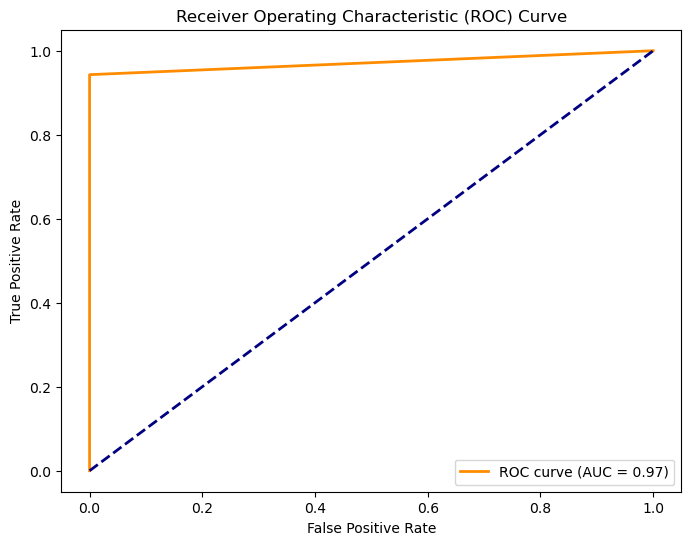

In [114]:

# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Evaluate the Model on TS set
    nn[dataset_i].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
    nn[dataset_i].score()

    # Prints the results obtained
    print(nn[dataset_i])
    nn[dataset_i].print_confusion_matrix()
    nn[dataset_i].print_roc_curve()


